# Explicit Optimization To Understand $\lambda$

$\newcommand{\mcU}{\mathcal{U}}$
$\newcommand{\flat}{\text{flat}}$
$\newcommand{\mcX}{\mathcal{X}}$
$\newcommand{\mcG}{\mathcal{G}}$
$\newcommand{\set}[1]{\{#1\}}$
$\newcommand{\ot}{{\Omega}_{\theta}}$
$\newcommand{\eps}{\epsilon}$
$\newcommand{\E}{\mathbf{E}}$
$\newcommand{\O}{\mathcal{O}}$
$\newcommand{\proj}{\mathcal{P}}$
$\newcommand{\abs}[1]{|#1|}$


The optimization program is a function of $p$ the risk of a model under source distribution, and $\delta$, the afforded radius around the source distribution.


# Optimization Program

Noting that $p := \langle f_p, \ot(1) \rangle$,
\begin{align*}
    F(p, \delta) 
    &:= \sup_{(r_0, r_1) \in \mcU_f(p, \delta)} pr_1  \\
        &\ \mcU_f = \set{(r_0, r_1) \mid p_0r_0 + p_1r_1 = 1, p_0f(r_0) +p_1 f(r_1) \le \delta, r_0, r_1 \ge 0}
\end{align*}


### $p := \langle f_p, I_{\Omega_\theta(1)}\rangle$ determines the entire dynamic

It is interesting that for any source distribution $f_p$, and model $\theta$, the only thing that determines the entire behaviour is the projection of $f_p$ onto $\Omega_\theta(1)$. This is surprising as the intuition we have in the general case is a geometric one, with some distribution $f_p$ and a `ball` around $f_p$ in some simplex $\Delta^{n-1}$. If that intuition were true, then there are two general cases with $\delta$ fixed. One when the ball is entirely contained in the simplex, such that all distributions within $\delta$ are valid cases. The other where the ball has an intersection with boundaries of the simplex. You'd expect handling these two cases will be reflected in your analysis.

What the analysis instead says is that the ambient dimension or how the ball fits in this dimension does not matter if you only consider the projection of $ f_p$ the source distribution on $\Omega_\theta(1)$. Dimension independent behaviour.



In [1]:
import numpy  as np
import matplotlib.pyplot as plt
import cvxpy as cp
from labellines import labelLine, labelLines

In [18]:
def cnstr_circle(x, p, delta):
    r = cp.power((x - 1), 2)
    p_ = np.array([1-p, p])
    return (r @ p_ <= delta)

def cnstr_entropy(x, p, delta):
    p_ = np.array([1-p, p])
    # Convert x to distribution
    q = cp.multiply(x, p_)
    return (cp.kl_div(q, p_) <= delta)


def opt_func(p, delta, cnstr=cnstr_circle):
    """
    Solves F(p, delta) with the convex function
    as func using cvxpy
    """
    assert cnstr in [cnstr_circle, cnstr_entropy]
    r = cp.Variable(2)
    max_obj = (np.array([0, p]) @ r)
    constr = [
        r >= 0,
        r @ [1-p, p] == 1,
        cnstr(r, p, delta),
    ]
    prob = cp.Problem(cp.Maximize(max_obj), constr)
    prob.solve()
    return r, prob

def get_q1(r, p):
    r0, r1 = r.value[:]
    q0 = r0 * (1-p)
    q1 = r1 * p
    assert np.abs(q0 + q1 -1) <= 0.0001
    return q0, q1


## Monotonicity of $F(p, \delta)$ in $p$ 

We know that $F(p, \delta)$ is monotonic and increasing in $p$ for any convex function $f$ such that $f(1) = 0$. This is implied and is in the proof of the monotonicity theorem.


## Monotonicity of $F(p, \delta)$ in $\delta$ 

The function is monotonically increasing in $\delta$ since the solution for smaller delta is in the feasible region for the larger delta. Moreover, the value at (1, 1) also changes with $p$ as the slop of the objective is changing. 

Note that for some $p' > p$, if $F(p', \delta = 0) > F(p, \delta)$ then $\lambda = 0$ is the only solution. How far can $p'$ be as a function of $p$ ?

In [19]:
p_range = np.arange(0, 1, 0.01)
delta_list = list(np.arange(0, 1, 0.1))
delta_list.extend([0.02, 0.05, 0.13, 0.15])
delta_list.sort()
result_dict = {}
for d_ in delta_list:
    val_list = [(opt_func(p_, d_)[1]).value for p_ in p_range]
    result_dict[d_] = val_list

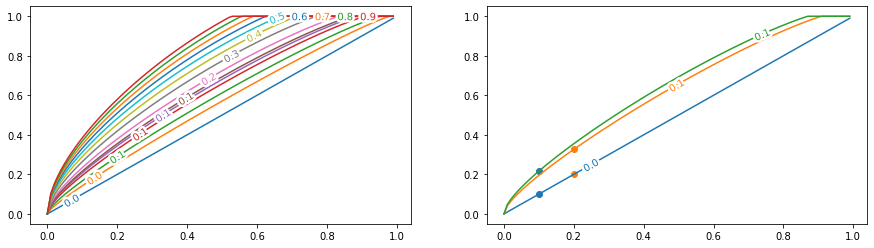

The objective value as a function of p for various values delta


In [20]:
fig = plt.figure(figsize=(15,4))
ax = plt.subplot(121)
for d_ in delta_list:
    ax.plot(p_range, result_dict[d_], '-', label=r'${%.1f}$' % d_)
labelLines(plt.gca().get_lines(), zorder=2.5)
ax = plt.subplot(122)
A, B = 0.1, 0.15
for d_ in [0.0, A, B]:
    ax.plot(p_range, result_dict[d_], '-', label=r'${%.1f}$' % d_)
# Small model regime
p, p_ = 0.1, 0.2
idx_p = list(p_range).index(p)
plt.scatter([p, p], [p, result_dict[B][idx_p]])
idx_p_ = list(p_range).index(p_)
plt.scatter([p_, p_], [p_, result_dict[A][idx_p_]])
labelLines(plt.gca().get_lines(), zorder=2.5)
plt.show()
print("The objective value as a function of p for various values delta")

### Using $f=-x\log x$

In [21]:
p_range = np.arange(0, 1, 0.01)
delta_list = list(np.arange(0, 1, 0.1))
delta_list.extend([0.02, 0.05, 0.13, 0.15])
delta_list.sort()
result_dict = {}
for d_ in delta_list:
    val_list = [(opt_func(p_, d_, cnstr_entropy)[1]).value for p_ in p_range]
    result_dict[d_] = val_list

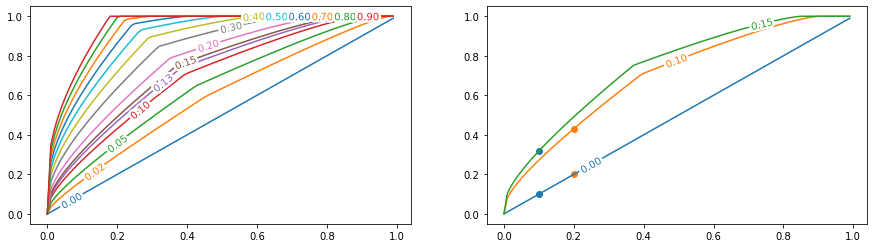

The objective value as a function of p for various values delta


In [22]:
fig = plt.figure(figsize=(15,4))
ax = plt.subplot(121)
for d_ in delta_list:
    ax.plot(p_range, result_dict[d_], '-', label=r'${%.2f}$' % d_)
labelLines(plt.gca().get_lines(), zorder=2.5)
ax = plt.subplot(122)
A, B = 0.1, 0.15
for d_ in [0.0, A, B]:
    ax.plot(p_range, result_dict[d_], '-', label=r'${%.2f}$' % d_)
# Small model regime
p, p_ = 0.1, 0.2
idx_p = list(p_range).index(p)
plt.scatter([p, p], [p, result_dict[B][idx_p]])
idx_p_ = list(p_range).index(p_)
plt.scatter([p_, p_], [p_, result_dict[A][idx_p_]])
labelLines(plt.gca().get_lines(), zorder=2.5)
plt.show()
print("The objective value as a function of p for various values delta")

## Inference for $f=(x-1)^2$ and $f=-x\log x$

|$f=-x\log x$| $f=(x-1)^2$ |
|----|---|
|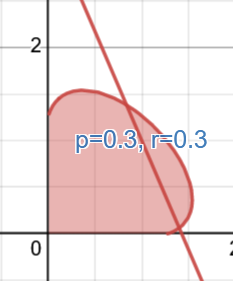|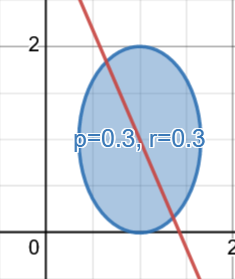|

Consider the following sequence of arguments;
1. Given a partition $\ot(1), \ot(0)$, every distribution $q$ such that $D_{f}(p|| q) \le \delta$ can be replaced with the distribution $\bar{q} := \exp_{p \mid\ot(0)}[q]I[\ot(0)] + \exp_{p\mid\ot(1)}[q]I[\ot(1)]$ such that $D_{f}(p||\bar{q} ) \le \delta $ and $R(q) = \exp_q[l_\theta] = \exp_p[l_\theta]$. 
2. Thus solving for the above reduction is equivalent to solving for $r_0, r_1$, for $F(p, \delta)$ in the desmos plot.
3. Now, the adversarial risk $F(p, \delta)$ is increasing in $p$ as we with its minimum positive value at $r =(1, 1)$. Thus the adversarial risk is maximized at the farthest point $r$ from $(1, 1)$. 
4. Even for a group based distribution, or any other form of restriction on shifts, it is true that the adversarial risk is maximized at some $q_g$ that is farthest from $(1, 1)$. Let $\delta_{g(p)} \le \delta$ correspond to the radius of the ball which has $q_g$ on the boundary. For us to be able to monotonicity, we need $F(p, \delta_{g(p)}) > F(p', \delta_{g(p')})$ for $p < p'$.

With this context, the above plots are disappointing, as its saying that,
1. $\forall \delta \ge 0$, $F(p, \delta) \rightarrow 0$ as $p\rightarrow 0$.  This in itself need not be a problem as the rates could be different, but here the rates seem to be $\O(\text{poly}(pL_f))$ for the lipschitz constant $L_f$ of $f$.
2. For any restricted set of shifts, say the best risk achieved is $p'$ through an AERM algorithm that considers this set of worst case distribution. There exists $\widetilde{p} < p'$, independent of the radius $\delta_{g(p)}$ such that for all $p \le \widetilde{p} < p'$,  $F(p, \delta_{g(p)}) < F(p', \delta_{g(p')})$. That is, there is only a small range of risk $|p - \widetilde{p}|$ in which we can break monotonicity, and this shrinks like $\O(\text{poly}({pL_f}))$.

**Proof:**  Given a $p'$ with risk $F(p', \delta=0) = p'$, clearly,  $ p' = F(p', \delta=0) \le F(p', \delta=1)$. Consider $F(p, \delta=1)$ for $p \in [0, p']$. Since $F(p, \delta=1) \rightarrow 0$ as $p\rightarrow 0$ and $0 \le F (p',\delta=0) \le F(p', \delta=1)$, from mean value theorem there exists $\widetilde{p}$ such that 
$$\forall \delta, F(\widetilde{p}, \delta) \le F(\widetilde{p}, \delta=1) \le F(p', \delta=0) \le F(p', \delta_{g(p')})\le F(p', \delta=1).$$ While it will need a bit of work to show formally, but from the picture it is clear that this set is the convex set $[0, \widetilde{p}]$ where it is not possible to break monotonicity.

3. No $p$-independent specification of the uncertainty set $\mcU_g$ can uniformly break monotonicity. Even a $p$ dependent definition of $\mcU_g$ can only break uncertainty in a range $[\widetilde{p}(p'), p']$. This window shrinks like $\text{poly}(p)$ which agrees with intuition.

That is to say,
1. If measured in $f$ measure, adversarial robustness can only be attained in a small neighbourhood.
2. What ever notion of restricted group we specify should thus somehow adapt to $p$. It is not possible uniformly and that agrees with intuition. 

## Inner Product over Partitions (Work in progress)

<!--
Fundamentally, we need some other notion of shift, say $g$ measure,
a) has low shift in $f$ measure but high shift in $g$ measure
b) captures semantic shifts. 

$f$ measure, which is in some sense euclidean measure between two distributions in function space, does not capture the right `types` of shift in some sense. 

The one clue we have is that distribution shift is really a problem of projection over partitions with the ambient dimension being not important. Moreover, we should be able to have a large movement over groups -- in some sense I'm not sure yet, that when measured in $f$ measure cancels out, but when measured in some other sense, adds up. (sum vs absolute sum or something like that).

The other clue is the notion of minority group and majority group and minority/majority flip. We seem to already be on the right track towards figuring out a notion of shift based on partitions. I feel we now know that,
1. This notion of shift requires to induce small $f$ measures, that somehow magically depend on $p$ and,
2. This notion of shift should not care about ambient dimension.


In particular, we know that shifts that preserve total mass over each partition, for partitions induced by $\theta \in \Theta$ have $D_f = 0$ for all $p$. The above analysis should precisely deal with the case when we allow some $\epsilon_(p)$ slack that depends on the quality of the models in $\Theta$ measured in risk $p$.
 -->


Some potentially useful definition.

**Projection:**
Let $A = \set{A_1, \dots, A_T}$ be some partition of $\mcX$ and let $q \in \Delta(\mcX)$ be some distribution over $\mcX$. Define the projection onto a partition $A$ as, $\proj_{A}: \Delta(\mcX) \rightarrow \Delta(\mcX)$, where
\begin{align*}
    \proj_{A}(x) &= \E_{A}\E_{q\mid A} [I[x \in A_i]]
\end{align*}

Thus the projection replaces the distribution $q$ with a point-wise average over $A$. In particular, $\proj_{A}(q)(x) = q(\set{A_i| x \in A_i(x)})$.

**Basis**

Fix some group definition $\mcG = \set{G_1, \dots, G_z}$. Fix some $l_{0-1}$ partition $\ot(0)$ and define,
\begin{align*}
G_0(i) := G(i) \cap \ot(0) \quad\text{and}\quad G_1(i) := G(i) \cap \ot(1)
\end{align*} We will now define some partitions that essentially will act as projection basis for the projection function defined above.

Define multi-sets and a flattening operation,
1. $B = \Big(\cup_i \set{G_0(i)}\Big)\cup\Big(\cup_i\set{ G_1(i)}\Big)$  such that $B(i) = G_0(i)$ for $1 \le i \le \abs{G}$  and $B(i) = G_1(i)$ for $\abs{G} < i \le 2\abs{G}$.
2. $B_0 = \cup_i\set{G_0(i)}$ and $B_1 = \cup_i\set {G_1(i)}$
3. $\flat(B) := \cup\set{x \mid x \in b \in B}$.

We have constructed two partitions, 
1. $B$
2. $\ot$ such that $\flat(B_0) = \ot(0)$ and $\flat(B_1) = \ot(1)$

**$(r_0, r_1)$ Equivalence classes**

Thus now we can formally define equivalent class $\bar{r}$
$$ \bar{r}(q) = \set{q' \mid \proj_{\set{B_0, B_1}}(q') = \proj_{\set{B_0, B_1}}(q)}$$

**Group Shifts**

With these definition we can also define the set of allowed definition with respect to the groups.

Define $\eps \in R^{\abs{G}}$. Then all the group shifts can be precisely characterized as,  
$$\set{q \mid q =  0 \le \proj_{G}(p) - \eps \le 1}$$





#### Special case I:  $F(p, \delta_g) - F(p, 0) = 0 \implies \lambda = 0$ 

Throughout we are keeping a $l_{0, 1}$ partition fixed and we want to understand if there are non-trivial group shifts that induce no change in adversarial risk. The answer should be False by definition, but thinking about this will help us think about the dynamics when we now vary the partition.

Let $\bar{r}(q)$ represent the $(r_0, r_1)$ reduction of a distribution $q$, with respect to some fixed partition. Note that $\E [\bar{r}(q) l_{0-1}] = \E[r(q) l_{0-1}]$ for all $q \in \bar{r}(q)$.  This set forms the equivalent class of $\bar{r}(q)$ and have the same adversarial risk. Note that *not* all distributions in $\bar{r}(q)$ are in $\text{cvx-hull}(U_f)$ where $U_f$ could be restricted or unrestricted.

Let $G_1, G_2, \dots, G_k$ form some partition of $\mathcal{X}$. Let $g_i = E_p[I(G_i)]$ be the density on partition $G_i$ under $p$. Then, the necessary and sufficient conditions to produce a group shift with zero movement in adversarial risk can be explicitly stated.

**Conditions for Zero shift**

Fixing a partition, all distributions in $\bar{r}(p)$ form an equivalent class as defined above. We use this fact.

Let $q_g$ be a group shift from $p$, and let $-1 \le \eps_i  \le 1$ be the change in the mass on partition $G_i$. That is, $\eps_i = E_q[I(G_i)] - E_p[I(G_i)]$. Then,

1. Valid group probability: $0  \le \E_p[I(G_i)] - \eps_i \le 1 $.
2. Conservation of mass on each side (equivalent class of $\bar{r}(p))$: 
$\bar{r}(q) = \bar{r}({p}).$

Since $(\bar{r}(p))(1) = \frac{\E_p[r(p)I(\ot(0))]}{\E_p[I(\ot(0)]} = 1$, we can restate the condition as $(\bar{r}(q))(1) = 1$. Now since we allow only groups shifts, $q \equiv g + \eps$ for some $\eps$ defined with respect a fixed group partition defined before. Therefore we require,


**Questions**

1. What is the relationship of $\delta$ and the members of $\bar{r}(f_p)$? In particular, can we find a distribution $q \in \bar{r}(f_p)$ for every $\delta$? Answer should be false, but why is it so?
2. What are the solution sets of (I)? Check for *[dense, convex, has interior]*.
